In [1]:
import os
import random

#data
import pandas as pd

# chemistry
import rdkit
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import Lipinski

# math
import numpy as np

# plotting
from matplotlib import pyplot as plt

# Machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier

Here I am training a Decision Tree model to classify if two pairs of ligands are suitable for template based docking:

1) The continuous rmsd values are divided into 2 classes: bellow 2 A and above 3 A

2) Values between 2 and 3 are considered inconclusive

3) Test set and training set don't have the same molecules

In [3]:
from tools import get_train_test_folds

no_inconcl_df, train_test_folds_indexes, train_test_folds_dfs = get_train_test_folds.get_train_test_folds(lower_threshold=2,
                                                                                               upper_threshold=3,
                                                                                                 number_of_repeats=3)
no_inconcl_df.head()

['template_HeavyAtomCount', 'template_NHOHCount', 'template_NOCount', 'template_RingCount', 'template_NumHAcceptors', 'template_NumHDonors', 'template_NumHeteroAtoms', 'template_NumRotatableBonds', 'docked_HeavyAtomCount', 'docked_NHOHCount', 'docked_NOCount', 'docked_RingCount', 'docked_NumHAcceptors', 'docked_NumHDonors', 'docked_NumHeteroAtoms', 'docked_NumRotatableBonds', 'mcs_HeavyAtomCount', 'mcs_NOCount', 'mcs_RingCount', 'mcs_NumHeteroAtoms', 'mcs_template_NHOHCount', 'mcs_docked_NHOHCount', 'mcs_template_NumHAcceptors', 'mcs_docked_NumHAcceptors', 'mcs_template_NumHDonors', 'mcs_docked_NumHDonors', 'mcs_template_NumRotatableBonds', 'mcs_docked_NumRotatableBonds', 'ec_tanimoto_similarity', 'fc_tanimoto_similarity', 'mcs_bonded_polar_sasa', 'mcs_bonded_apolar_sasa', 'mcs_unbonded_polar_sasa', 'mcs_unbonded_apolar_sasa', 'sasa_bonded_polar', 'sasa_bonded_apolar', 'sasa_unbonded_polar', 'sasa_unbonded_apolar', 'group']
{1: 6855, 2: 4034, 5: 733, 6: 892, 9: 361, 10: 658, 11: 569, 1

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,mcs_bonded_polar_sasa,mcs_bonded_apolar_sasa,mcs_unbonded_polar_sasa,mcs_unbonded_apolar_sasa,sasa_bonded_polar,sasa_bonded_apolar,sasa_unbonded_polar,sasa_unbonded_apolar,group,binned_rmsd
0,2JH5_895,1ZRB_062,6.813,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,NCc1ccc(Cl)cc1CNC(=O)[C@@H]1CCCN1C(=O)[C@@]1(O...,[#6]-[#6](-[#6](=[#8])-[#7]-[#6]-[#6])-[#7](-[...,28,1,8,...,21.671938,61.229232,54.463312,185.918549,48.245348,73.835544,214.880999,407.758869,1,0
1,2JH5_895,3QWC_98P,5.856,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,C[n+]1ccc(Cl)c(CNC(=O)[C@@H]2CCCN2C(=O)[C@H](N...,[#6]-[#6]-[#7]-[#6](=[#8])-[#6](-[#6])-[#7](-[...,28,1,8,...,27.777119,61.229232,63.923964,185.918549,48.245348,73.835544,214.880999,407.758869,1,0
2,2JH5_895,1MUE_CDD,8.229,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,O=C(Cn1c(Cl)cnc(NCC(F)(F)c2cccc[n+]2[O-])c1=O)...,"[#6](-,:[#6](=[#8])-,:[#7](-[#6]-[#6])-,:[#6]-...",28,1,8,...,20.905065,48.767619,37.666173,181.830981,48.245348,73.835544,214.880999,407.758869,1,0
3,2JH5_895,4YES_45S,3.128,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,Cc1ccc(C(=O)N2CCC[C@H]2C(=O)NCc2cc(Cl)ccc2CN)[...,"[#6]:,-[#6]:,-[#6](-[#6](=[#8])-[#7]-[#6](-[#6...",28,1,8,...,27.777119,61.229232,63.923964,185.918549,48.245348,73.835544,214.880999,407.758869,1,0
4,2JH5_895,1TA2_176,6.158,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,N[C@@H](C(=O)N1CCC[C@H]1C(=O)NCc1cc(Cl)ccc1Cl)...,[#6]-[#6](-[#6](=[#8])-[#7]-[#6]-[#6])-[#7](-[...,28,1,8,...,27.777119,61.229232,63.923964,185.918549,48.245348,73.835544,214.880999,407.758869,1,0


In [36]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(estimator=RandomForestClassifier(class_weight="balanced", max_depth=3, n_jobs=-1),
                 param_grid={'n_estimators':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30]},#'max_samples':np.linspace(0.1,1,15).tolist()},
                 scoring={'f1_score':sklearn.metrics.make_scorer(sklearn.metrics.f1_score),
                          'recall':sklearn.metrics.make_scorer(sklearn.metrics.recall_score),
                          'precision':sklearn.metrics.make_scorer(sklearn.metrics.precision_score),
                           'roc_auc':sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score)},
                 refit=False,
                 n_jobs=-1,
                 cv=train_test_folds_indexes,
                 verbose=1)

In [4]:
not_features = ['template', 'docked', 'rmsd', 'uniprot_id', 'mcs_smartsString',
                    'smiles_template', 'smiles_docked', 'binned_rmsd']

In [ ]:
feats = no_inconcl_df.drop(columns=not_features + ['group']).values.tolist()
labels = no_inconcl_df[['binned_rmsd']].values.tolist()

In [38]:
clf.fit(feats, labels)

Fitting 12 folds for each of 22 candidates, totalling 264 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:  4.2min finished


GridSearchCV(cv=[[array([11695, 11696, 11697, ..., 18119, 18120, 18121]),
                  array([20017, 20018, 20019, ..., 18871, 18872, 18873])],
                 [array([20017, 20018, 20019, ..., 18119, 18120, 18121]),
                  array([11695, 11696, 11697, ..., 19975, 19976, 19977])],
                 [array([20017, 20018, 20019, ..., 18119, 18120, 18121]),
                  array([19894, 19895, 19896, ..., 19093, 20028, 20034])],
                 [array([20017, 20018, 20019, ..., 190...
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=3, n_jobs=-1),
             n_jobs=-1,
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 25,
                                          30]},
             refit=False,
             scoring={'f1_score': make_scorer(f1_score),
                      'precision': make

In [39]:
cv_results = clf.cv_results_
cv_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_estimators', 'params', 'split0_test_f1_score', 'split1_test_f1_score', 'split2_test_f1_score', 'split3_test_f1_score', 'split4_test_f1_score', 'split5_test_f1_score', 'split6_test_f1_score', 'split7_test_f1_score', 'split8_test_f1_score', 'split9_test_f1_score', 'split10_test_f1_score', 'split11_test_f1_score', 'mean_test_f1_score', 'std_test_f1_score', 'rank_test_f1_score', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'split5_test_recall', 'split6_test_recall', 'split7_test_recall', 'split8_test_recall', 'split9_test_recall', 'split10_test_recall', 'split11_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'split5_test_precision', 'split6_test_precision', 'split7_test_precision', 'split8

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 25 30]


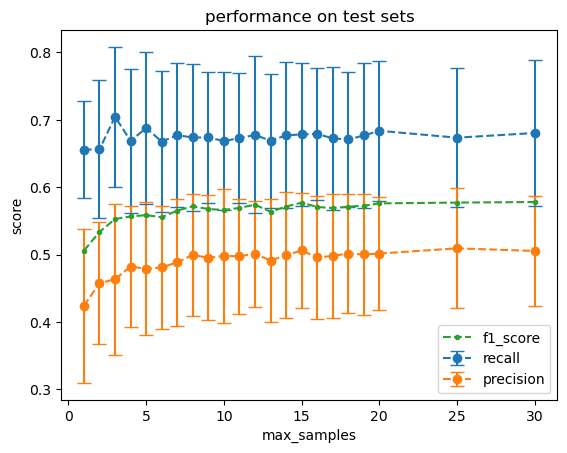

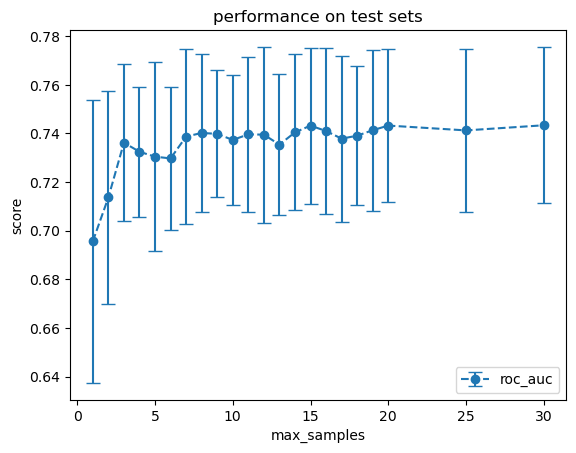

In [40]:
print(cv_results['param_n_estimators'].data) # [4, 5, 6, 7, 8, 9, 10, 15, 20]
# cv_results['param_max_samples'].data
plt.style.use('default')
plt.errorbar(cv_results['param_n_estimators'].data,y=cv_results['mean_test_recall'], yerr=cv_results['std_test_recall'], capsize=5, fmt='--o', label='recall')
plt.errorbar(cv_results['param_n_estimators'].data,y=cv_results['mean_test_precision'], yerr=cv_results['std_test_precision'], capsize=5, fmt='--o', label='precision')
plt.plot(cv_results['param_n_estimators'].data, cv_results['mean_test_f1_score'], '--.',label='f1_score')
plt.xlabel('max_samples')
plt.ylabel('score')
plt.legend()
plt.title('performance on test sets')
plt.show()

plt.errorbar(cv_results['param_n_estimators'].data,y=cv_results['mean_test_roc_auc'], yerr=cv_results['std_test_roc_auc'], capsize=5, fmt='--o', label='roc_auc')
plt.xlabel('max_samples')
plt.ylabel('score')
plt.legend()
plt.title('performance on test sets')
plt.show()


In [6]:
train_test=random.sample(train_test_folds_dfs, len(train_test_folds_dfs)).copy()

clf = RandomForestClassifier(max_depth=3,n_estimators=15, class_weight="balanced")

In [42]:
from sklearn import inspection

rr = []
for train, test in train_test:

    _feats_train = train.drop(columns=not_features + ['group']).values.tolist()
    _labels_train = train[['binned_rmsd']].values.tolist()
    _feats_test = test.drop(columns=not_features + ['group']).values.tolist()
    _labels_test = test[['binned_rmsd']].values.tolist()

    clf = clf.fit(_feats_train, _labels_train)

    r = inspection.permutation_importance(clf, _feats_test, _labels_test,
                                      scoring=sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score),
                                      n_repeats=100,
                                      n_jobs=-1)
    rr += [r]

/home/fol007/anaconda3/envs/py37_rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/fol007/anaconda3/envs/py37_rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/fol007/anaconda3/envs/py37_rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/fol007/anaconda3/envs/py37_rdkit/lib/python3.7/site-packages/ipykernel_launc

In [7]:
features = no_inconcl_df.drop(columns=not_features).columns.tolist()

In [ ]:
r = {'importances_mean': 0,
     'importances_std': 0}
for i in rr:
    r['importances_mean'] += i['importances_mean']/len(rr)
    r['importances_std'] += i['importances_std']/len(rr)

for i in r['importances_mean'].argsort()[::-1]:
    if r['importances_mean'][i] - 1 * r['importances_std'][i] > 0:
        print(f"{features[i]:<30}"
              f"{r['importances_mean'][i]:.3f}"
              f" +/- {r['importances_std'][i]:.3f}")

In [8]:
for train, test in train_test:
    train['dt_score'] = None
    test['dt_score'] = None

tops = [1,2,3]
range_of_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
proportion_top = []
range_of_top = [1,2,3,4,5,6,7,8,9,10]
proportion_thresh = {top:[] for top in tops}
valids_thresh = {top:[] for top in tops}
for train, test in train_test:
    _feats_train = train.drop(columns=not_features + ['group', 'dt_score']).values.tolist()
    _labels_train = train[['binned_rmsd']].values.tolist()
    _feats_test = test.drop(columns=not_features + ['group', 'dt_score']).values.tolist()
    clf = clf.fit(_feats_train, np.ravel(_labels_train))
    test['dt_score'] = clf.predict_proba(_feats_test)[:,1]
    _proportion = []
    for i in range_of_top:
        count = 0
        for docked in test['docked'].drop_duplicates().values:
                if test.loc[(test['docked']==docked)] \
                                     .sort_values(by=['dt_score'], ascending=False)[:i] \
                                     .loc[test['rmsd']<2].shape[0] > 0:
                    count += 1
        _proportion += [count/test[test['rmsd']<2]['docked'].drop_duplicates().shape[0]]#test['docked'].drop_duplicates().shape[0]]
    proportion_top += [_proportion]

    for top in tops:
        _proportion = []
        _valids = []
        for i in range_of_thresholds:
            count = 0
            valid = 0
            for docked in test['docked'].drop_duplicates().values:
                if test.loc[(test['docked']==docked) & (test['rmsd']<2)].shape[0] > 0:
                    if test.loc[(test['docked']==docked)
                                              & (test['dt_score']>i)].shape[0] > 0:
                        valid += 1
                        if test.loc[(test['docked']==docked) & (test['dt_score']>i)] \
                                             .sort_values(by=['dt_score'], ascending=False)[:top] \
                                             .loc[test['rmsd']<2].shape[0] > 0:
                            count += 1
            _valids += [valid/test[test['rmsd']<2]['docked'].drop_duplicates().shape[0]]#test['docked'].drop_duplicates().shape[0]]
            if valid == 0:
                _proportion += [0]
            else:
                _proportion += [count/valid]
        proportion_thresh[top] += [_proportion]
        valids_thresh[top] += [_valids]

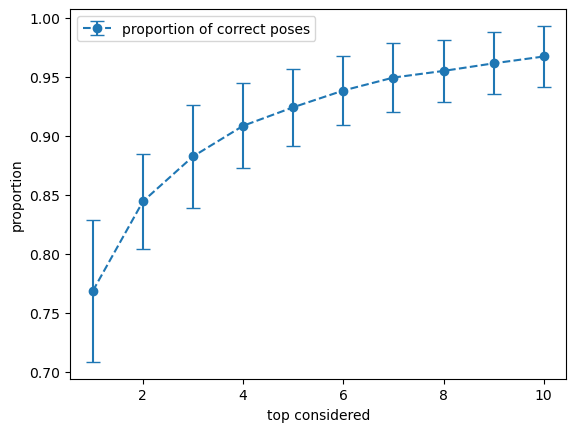

In [9]:
plt.style.use('default')
mean_proportion_top = []
std_proportion_top = []
for i in range(len(range_of_top)):
    mean_proportion_top += [np.mean(np.array(proportion_top)[:,i])]
    std_proportion_top += [np.std(np.array(proportion_top)[:,i])]

plt.errorbar(range_of_top, mean_proportion_top, yerr=std_proportion_top, capsize=5, fmt='--o', label='proportion of correct poses')
plt.xlabel('top considered')
plt.ylabel('proportion')
plt.legend()
plt.show()

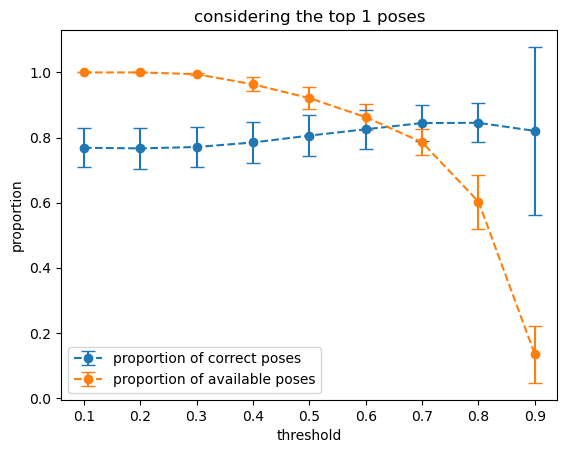

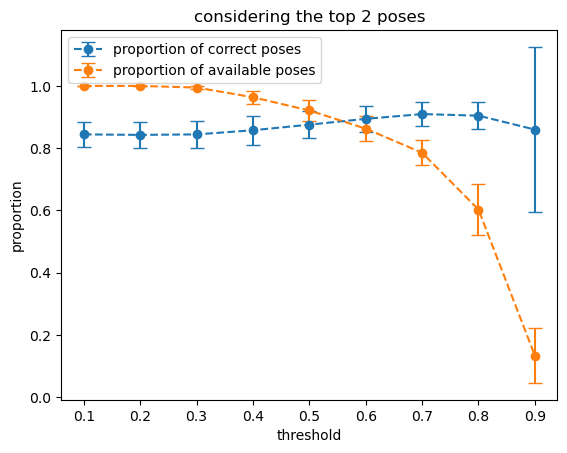

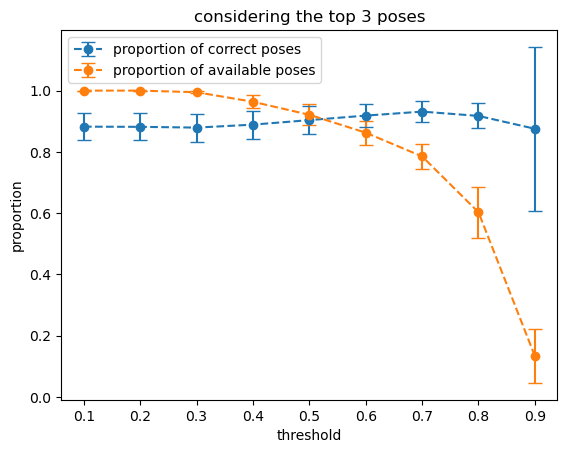

In [10]:
plt.style.use('default')
for top in tops:
    mean_proportion_thresh = []
    mean_valids_thresh = []
    std_proportion_thresh = []
    std_valids_thresh = []
    for i in range(len(range_of_thresholds)):
        mean_proportion_thresh += [np.mean(np.array(proportion_thresh[top])[:,i])]
        mean_valids_thresh += [np.mean(np.array(valids_thresh[top])[:,i])]
        std_proportion_thresh += [np.std(np.array(proportion_thresh[top])[:,i])]
        std_valids_thresh += [np.std(np.array(valids_thresh[top])[:,i])]

    plt.errorbar(range_of_thresholds, mean_proportion_thresh, yerr=std_proportion_thresh, capsize=5, fmt='--o', label='proportion of correct poses')
    plt.errorbar(range_of_thresholds, mean_valids_thresh, yerr=std_valids_thresh, capsize=5, fmt='--o', label='proportion of available poses')
    plt.xlabel('threshold')
    plt.ylabel('proportion')
    plt.ylim([0.5,1.1])
    plt.title('considering the top '+str(top)+' poses')
    plt.legend()
    plt.show()
    '''
    plt.plot(range_of_thresholds, std_proportion_thresh, '--o', label='std of proportion of correct poses')
    plt.plot(range_of_thresholds, std_valids_thresh, '--o', label='std of proportion of available poses')
    plt.xlabel('threshold')
    plt.ylabel('standard deviation')
    plt.title('considering the top '+str(top)+' poses')
    plt.ylim([0,0.1])
    plt.legend()
    plt.show()
    '''